In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import os
import random
import timeit
from keras.models import load_model, Model
from PIL import Image
from pymongo import MongoClient
from sklearn.metrics.pairwise import euclidean_distances

from ajna_commons.flask.conf import DATABASE, MONGODB_URI
from utils import monta_lista_ids_e_imagens, view_imagens

MODELO = 'GPUNormal100Epoch'

/home/ivan/pybr/ajna_docs/padma/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def get_cursor_indices(limit=50000, batch_size=1000):
    db = MongoClient(host=MONGODB_URI)[DATABASE]
    cursor = db['fs.files'].find(
        {'metadata.predictions.index': {'$exists': True, '$ne': None}},
        {'metadata.predictions.index': 1}
    ).limit(limit).batch_size(batch_size)
    return cursor


In [4]:
cursor = get_cursor_indices(1000000)

In [5]:
indexes = list(cursor)

In [6]:
len(indexes)

323622

In [7]:
print(indexes[0])

{'metadata': {'predictions': [{'index': [0.07849450409412384, 1.2960327863693237, 0.0, 0.667670726776123, 0.20329152047634125, 0.0, 0.0, 0.4449634850025177, 0.0, 0.9783217310905457, 0.0, 0.5244067907333374, 0.028263315558433533, 0.0, 0.022635802626609802, 0.2349385917186737, 0.0, 1.0338417291641235, 0.0, 0.5350226163864136, 0.0, 0.0, 0.005886092782020569, 0.31447580456733704, 0.0, 1.3389369249343872, 0.14487135410308838, 0.4333502948284149, 0.5755405426025391, 0.0, 0.13025207817554474, 0.14246486127376556, 0.09010772407054901, 1.0005420446395874, 0.0, 0.5512406826019287, 0.21090786159038544, 0.0, 0.0, 0.28459614515304565, 0.0, 0.8176745772361755, 0.0, 0.48344936966896057, 0.1305152326822281, 0.0, 0.0, 0.050363048911094666, 0.0, 1.071012258529663, 0.0, 0.6772755980491638, 0.06329227983951569, 0.0, 0.0, 0.15864036977291107, 0.0, 1.3415133953094482, 0.40365949273109436, 0.630198061466217, 0.42874205112457275, 0.0, 0.0, 0.35331812500953674, 0.0, 0.5547448396682739, 0.0, 0.20432570576667786

In [8]:
def monta_indexes():
    np_indexes = [index.get('metadata').get('predictions')[0].get('index') for index in indexes[2:]]
    return np.asarray(np_indexes, dtype=np.float16)


In [9]:
timeit.timeit(stmt='monta_indexes()', number=1, globals=globals())


1.8703007419826463

In [10]:
np_indexes = monta_indexes()

In [11]:
print(np_indexes.shape)
print("%d kbytes" % ((np_indexes.size * np_indexes.itemsize) / 1000))

(323620, 128)
82846 kbytes


In [12]:
def get_distances():
    i = random.randint(0, np_indexes.shape[0] - 1)
    distances = euclidean_distances([np_indexes[i]], np_indexes)
    sequence = np.argsort(distances)
    return i, distances, sequence


In [13]:
timeit.timeit(stmt='get_distances()', number=10, globals=globals())

5.038802852999652

In [14]:
timeit.timeit(stmt='get_distances()', number=20, globals=globals())

9.834014028980164

In [15]:
timeit.timeit(stmt='get_distances()', number=50, globals=globals())

24.794931272015674

In [16]:
from gridfs import GridFS
from bson.objectid import ObjectId
import io

def mongo_image(image_id):
    """Lê imagem do Banco MongoDB. Retorna None se ID não encontrado."""
    db = MongoClient(host=MONGODB_URI)[DATABASE]
    fs = GridFS(db)
    # _id = ObjectId(image_id)
    _id = image_id
    if fs.exists(_id):
        grid_out = fs.get(_id)
        image = grid_out.read()
        return Image.open(io.BytesIO(image))
    return None

In [17]:
i, dist, seq = get_distances()
seq = seq.reshape(seq.shape[1])
seq.shape

(323620,)

In [18]:
lista_ids = [index.get('_id') for index in indexes[2:]]
lista_ids = np.asarray(lista_ids)
lista_ids[seq[0]]


ObjectId('5aa1e3f32a87950ba4ac2dc8')

In [19]:
np.save('indexes.npy', np_indexes)
np.save('_ids.npy', np.asarray(lista_ids))

[282352 126328 196821 221302 282890 115271 286270   9467 286537 282311
 309484 229567 229599 282535  36151 114063 309310 192537  78045 229602]


/home/ivan/pybr/ajna_docs/padma/venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

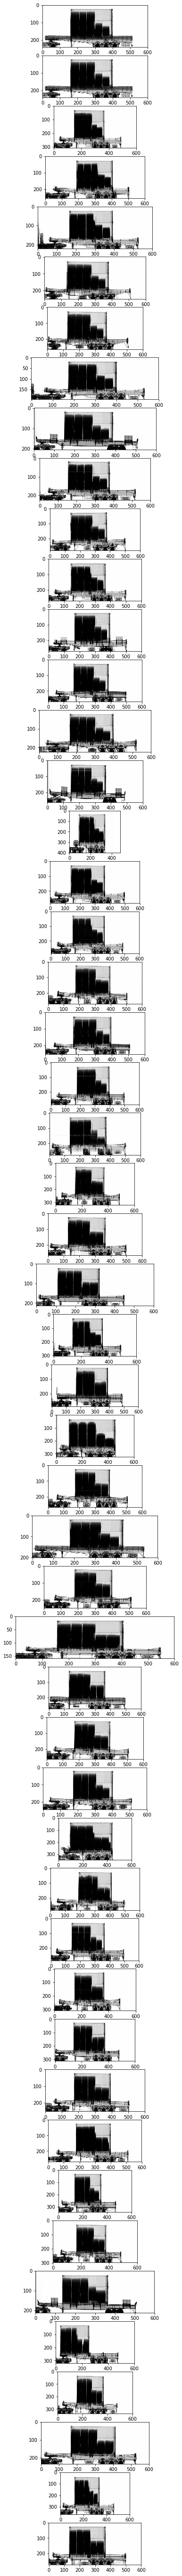

In [21]:
i, dist, seq = get_distances()
seq = seq.reshape(seq.shape[1])
print(seq[:20])

plt.gray()
fig=plt.figure(figsize=(10, 100))
for r in range(50):
    ax = fig.add_subplot(51, 1, 1)
    plt.imshow(mongo_image(lista_ids[i]))
    ax = fig.add_subplot(51, 1, r + 2)
    plt.imshow(mongo_image(lista_ids[seq[r]]))
plt.show()